In [1]:
import pandas as pd
import time
import re
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
from statsmodels.graphics.regressionplots import abline_plot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV



In [249]:
df_wnba=pd.read_pickle('pickles/df_wnba')
df_wnba_pg=pd.read_pickle('pickles/df_wnba_pg')
df_wnba_adv=pd.read_pickle('pickles/df_wnba_adv')
df_allstar=pd.read_csv('pickles/allstar.csv')
df_draft = pd.read_csv('pickles/draft.csv')
salary=pd.read_pickle('pickles/salary')


In [241]:
df_draft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1062 entries, 0 to 1061
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    1062 non-null   int64  
 1   Pick    1043 non-null   float64
 2   Player  1062 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 25.0+ KB


In [250]:
df_stats1=pd.merge(left=df_wnba, right=df_wnba_pg, on = ['Player','Year'], #928 rows × 44 columns
            suffixes=('', 'pg'))
df_stats2=pd.merge(left=df_stats1, right=df_wnba_adv, on = ['Player','Year'], #928 rows × 75 columns
            suffixes=('', 'adv'))
df_stats3=pd.merge(left=df_stats2, right=df_allstar, how='left',on = ['Player','Year'])
df_stats=pd.merge(left=df_stats3, right=df_draft, how='left',on = ['Player'],suffixes=('', 'draft'))
df_stats.columns

Index(['Player', 'Team', 'Pos', 'G', 'MP', 'GS', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year', 'Teampg', 'Pospg',
       'Gpg', 'MPpg', 'GSpg', 'FGpg', 'FGApg', 'FG%pg', '3Ppg', '3PApg',
       '3P%pg', '2Ppg', '2PApg', '2P%pg', 'FTpg', 'FTApg', 'FT%pg', 'ORBpg',
       'TRBpg', 'ASTpg', 'STLpg', 'BLKpg', 'TOVpg', 'PFpg', 'PTSpg', 'Teamadv',
       'Posadv', 'Gadv', 'MPadv', 'PER', 'TS%', 'eFG%', '3PAr', 'FTr', 'ORB%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'ORtg', 'DRtg', 'OWS',
       'DWS', 'WS', 'WS/40', 'AllStar', 'TTLAllStar', 'Yeardraft', 'Pick'],
      dtype='object')

In [251]:
df[(df.Player =='Rebecca Allen')]
#df_allstar[(df_allstar.Player == 'Diana Taurasi')&(df_allstar.Year == 2021)]
#df_stats[(df_stats.Player == 'Diana Taurasi')&(df_allstar.Year == 2021)]#

,Player,Team,Pos,G,MP,GS,FG,FGA,FG%,3P,...,OWS,DWS,WS,WS/40,AllStar,TTLAllStar,Yeardraft,Pick,average,salary_cap
3,Rebecca Allen,NYL,F,25.0,615.0,13.0,74.0,216.0,0.343,48.0,...,0.3,0.9,1.2,0.075,NaN,NaN,2015.0,NaN,105037.0,1339000
326,Rebecca Allen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80800.0,1300000
348,Rebecca Allen,NYL,F,24.0,412.0,2.0,65.0,156.0,0.417,29.0,...,0.5,0.2,0.6,0.059,NaN,NaN,2015.0,NaN,80800.0,996100
519,Rebecca Allen,NYL,F,28.0,291.0,0.0,38.0,101.0,0.376,10.0,...,-0.2,0.3,0.1,0.011,NaN,NaN,2015.0,NaN,56100.0,976300
683,Rebecca Allen,NYL,F,33.0,304.0,0.0,38.0,101.0,0.376,15.0,...,-0.2,0.7,0.5,0.070,NaN,NaN,2015.0,NaN,NaN,959394
840,Rebecca Allen,NYL,F,21.0,280.0,6.0,45.0,98.0,0.459,17.0,...,0.5,0.4,0.9,0.134,NaN,NaN,2015.0,NaN,NaN,942489


In [252]:
salary[(salary.Player =='Rebecca Allen')]

,Player,base,Year,salary
57,Rebecca Allen,105037,2021,105037.0
222,Rebecca Allen,81600,2020,80800.0
395,Rebecca Allen,80000,2019,80800.0
538,Rebecca Allen,56100,2018,56100.0


In [253]:
#salary cap table from https://herhoopstats.com/wnba_cba_salary_cap_explained
#2016 and 2017 did not have a salary cap in operation, so assumption was used

salary_cap = {
    2016: 942489,
    2017: 959394,
    2018: 976300,
    2019: 996100,
    2020: 1300000,
    2021: 1339000
}
df_cap= pd.DataFrame(salary_cap.items(),columns=['Year','salary_cap'])
df_cap

,Year,salary_cap
0,2016,942489
1,2017,959394
2,2018,976300
3,2019,996100
4,2020,1300000
5,2021,1339000


In [254]:
#merge stats with salaries and yearly max cap info

df=pd.merge(left=df_stats, right=salary,
            how='inner',
            left_on=['Player','Year'], 
            right_on=['Player','Year'])
df=pd.merge(left=df, right = df_cap,
            how='inner',
            on=['Year'])

df.groupby('Year').count()['Player'] #543 x 48  


Year
2016      5
2017     21
2018     94
2019    149
2020    138
2021    140
Name: Player, dtype: int64

In [255]:
#calculate salary as a % of cap
df['%CAP']= df['salary']/df['salary_cap'] 

#calculate number of years in the league
df['years_active']= df['Year']- df['Yeardraft']+1 #they play in the year they were drafted so add one


In [256]:

#columns to keep for smaller dataframe
df=df[['Year','Player','Team' ,'Pos','G', 'MP', 'GS', 'FG%', '3P%',  '2P%',  'FT%', #overall game metrics
    'MPpg', 'FGpg','3Ppg', '2Ppg', 'FTpg', 'TRBpg', 'ASTpg', 'STLpg', 'BLKpg',  'PFpg', 'PTSpg', #pergame metrics
    'PER','TS%','eFG%', '3PAr', 'FTr','USG%', 'ORtg', 'DRtg', 'WS', 'AllStar','TTLAllStar','years_active','Pick',#advanced metrics
    'salary_cap','%CAP']]# target

#drop players who didn't play any minutes all season
df = df[df.MP != 0]

In [257]:
#if they weren't drafted, set Pick as 65 (max draft number is 64)
df.Pick.fillna(65,inplace=True)
#if they didn't play or didn't score, the field is NA - NA should be set to zero
df.fillna(0,inplace=True)
np.isnan(df[['G', 'MP', 'GS', 'FG%', '3P%',  '2P%',  'FT%', #overall game metrics
    'MPpg', 'FGpg','3Ppg', '2Ppg', 'FTpg', 'TRBpg', 'ASTpg', 'STLpg', 'BLKpg',  'PFpg', 'PTSpg', #pergame metrics
    'PER','TS%','eFG%', '3PAr', 'FTr','USG%', 'ORtg', 'DRtg', 'WS', 'AllStar','TTLAllStar','years_active','Pick',#advanced metrics
    '%CAP']]).sum() #check infinities

G               0
MP              0
GS              0
FG%             0
3P%             0
2P%             0
FT%             0
MPpg            0
FGpg            0
3Ppg            0
2Ppg            0
FTpg            0
TRBpg           0
ASTpg           0
STLpg           0
BLKpg           0
PFpg            0
PTSpg           0
PER             0
TS%             0
eFG%            0
3PAr            0
FTr             0
USG%            0
ORtg            0
DRtg            0
WS              0
AllStar         0
TTLAllStar      0
years_active    0
Pick            0
%CAP            0
dtype: int64

In [152]:
df.corr()


,Year,G,MP,GS,FG%,3P%,2P%,FT%,MPpg,FGpg,...,FTr,USG%,ORtg,DRtg,WS,AllStar,TTLAllStar,years_active,Pick,%CAP
Year,1.000000,-0.313864,-0.179418,-0.132461,-0.060866,0.006159,-0.046318,-0.065271,-0.179418,-0.054977,...,-0.086487,-0.052227,-0.111059,-0.067680,-0.163243,-0.090610,-0.067242,0.008021,0.040287,-0.083294
G,-0.313864,1.000000,0.763671,0.530576,0.270589,0.132681,0.212717,0.353429,0.763671,0.331669,...,0.003767,0.121530,0.329410,-0.130319,0.441640,0.179736,0.034619,0.058504,-0.092088,0.184919
MP,-0.179418,0.763671,1.000000,0.885016,0.332966,0.224487,0.295870,0.397022,1.000000,0.753716,...,0.045700,0.368074,0.424539,-0.127453,0.711797,0.395305,0.247464,0.240884,-0.211572,0.434085
GS,-0.132461,0.530576,0.885016,1.000000,0.306926,0.181578,0.273296,0.316178,0.885016,0.739142,...,0.033208,0.332168,0.381689,-0.127111,0.685419,0.398707,0.305642,0.279088,-0.192399,0.461290
FG%,-0.060866,0.270589,0.332966,0.306926,1.000000,0.082492,0.837532,0.300307,0.332966,0.474046,...,0.184962,0.205530,0.807177,-0.221541,0.503443,0.185638,0.153597,0.138722,-0.143961,0.191037
3P%,0.006159,0.132681,0.224487,0.181578,0.082492,1.000000,0.029771,0.279474,0.224487,0.246698,...,-0.221551,0.234471,0.309209,0.084402,0.158145,0.118411,0.106448,0.101095,-0.026923,0.153499
2P%,-0.046318,0.212717,0.295870,0.273296,0.837532,0.029771,1.000000,0.287455,0.295870,0.413279,...,0.163048,0.179873,0.667641,-0.138002,0.435643,0.175340,0.146678,0.139980,-0.125010,0.174361
FT%,-0.065271,0.353429,0.397022,0.316178,0.300307,0.279474,0.287455,1.000000,0.397022,0.384804,...,0.233570,0.363575,0.511008,0.023569,0.269824,0.138412,0.146094,0.123922,-0.061158,0.233352
MPpg,-0.179418,0.763671,1.000000,0.885016,0.332966,0.224487,0.295870,0.397022,1.000000,0.753716,...,0.045700,0.368074,0.424539,-0.127453,0.711797,0.395305,0.247464,0.240884,-0.211572,0.434085
FGpg,-0.054977,0.331669,0.753716,0.739142,0.474046,0.246698,0.413279,0.384804,0.753716,1.000000,...,0.107355,0.713908,0.491779,-0.153170,0.742118,0.530587,0.386054,0.277978,-0.309727,0.517895


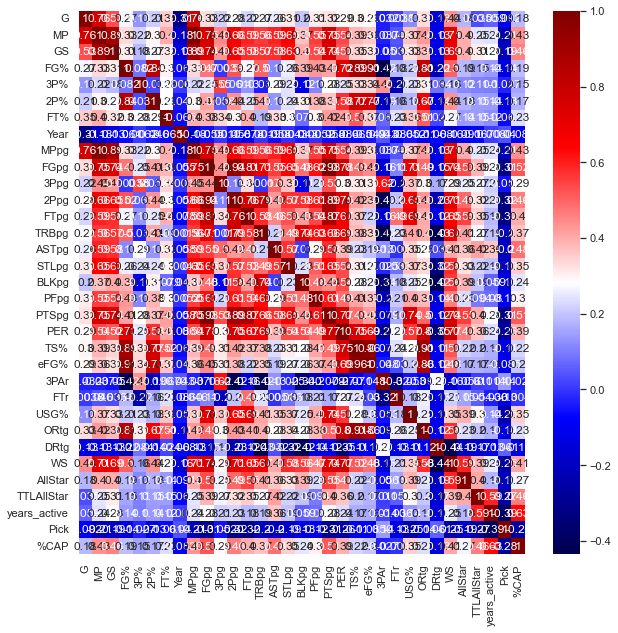

In [292]:
#visualize correlations
sns.heatmap(df.corr(), cmap="seismic",annot=True)

sns.set(rc = {'figure.figsize':(20,20)})

In [258]:
corr=pd.DataFrame(df.corr()['%CAP'].sort_values(ascending= False))
corr.head(30)


,%CAP
%CAP,1.000000
years_active,0.639544
FGpg,0.515736
PTSpg,0.509469
TTLAllStar,0.483971
GS,0.471604
ASTpg,0.468929
2Ppg,0.461793
MPpg,0.435635
MP,0.435635


In [263]:
#add interactions - features which had high correlations with each other
#df['STLpgxASTpg']=df['STLpg']*df['ASTpg']
#df['GSxMPpg']= df['GS']*df['MPpg']
#df['MPpgxFGpg']=df['MPpg']*df['FGpg']
#df['MPpgxASTpg']=df['MPpg']*df['ASTpg']
#df['MPpgxTRBpg']=df['MPpg']*df['TRBpg']
#df['TRBpgxFGpg']=df['TRBpg']*df['FGpg']
df['FGpgxASTpg']=df['FGpg']*df['ASTpg']



In [225]:
df.columns

Index(['Year', 'Player', 'Team', 'Pos', 'G', 'MP', 'GS', 'FG%', '3P%', '2P%',
       'FT%', 'MPpg', 'FGpg', '3Ppg', '2Ppg', 'FTpg', 'TRBpg', 'ASTpg',
       'STLpg', 'BLKpg', 'PFpg', 'PTSpg', 'PER', 'TS%', 'eFG%', '3PAr', 'FTr',
       'USG%', 'ORtg', 'DRtg', 'WS', 'AllStar', 'TTLAllStar', 'years_active',
       'Pick', 'salary_cap', '%CAP', 'FGpgxASTpg'],
      dtype='object')

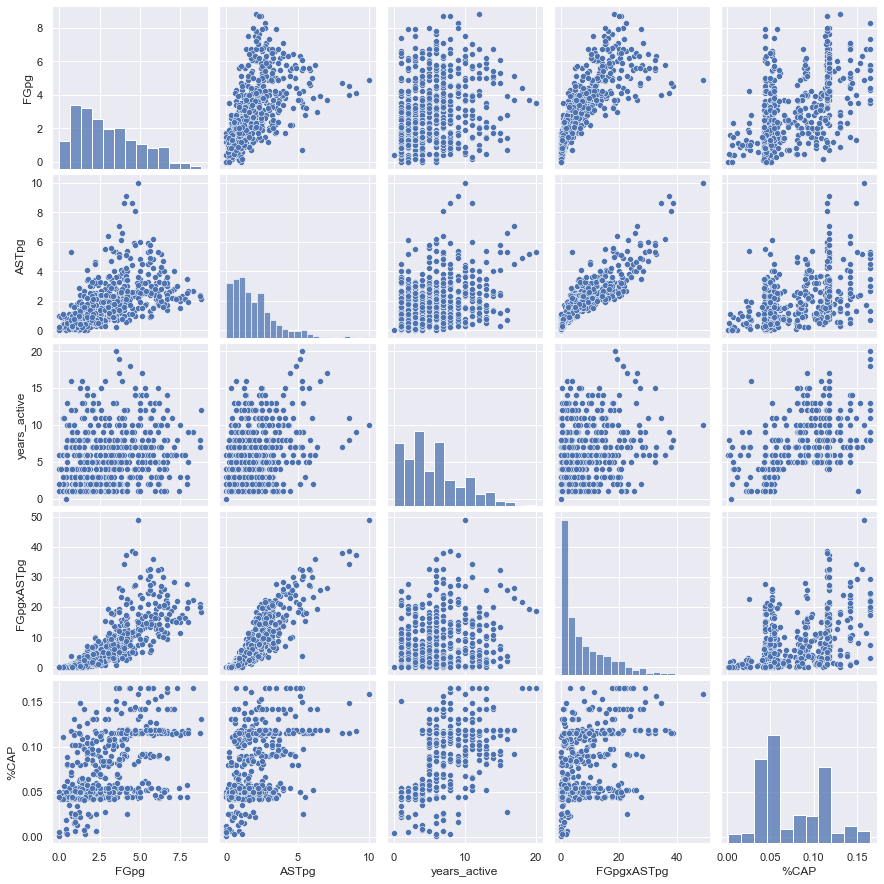

In [226]:
sns.pairplot(pd.concat([df[columns], df['%CAP']],axis=1))


In [227]:
# different model versions:
# Run 1 [ 'GS','MPpg','FGpg','ASTpg'] R squared 0.3 -- first try didn't include years active, tried to minimize p-values and VIFs
# Run 2 ['FGpg','ASTpg','years_active','Pick'] R squared 0.5 -- minimise P values all below <0.05
# Run 3 ['FGpg','ASTpg','years_active','FGpgxASTpg'] R squared 0.5 -- used lasso regression to zero out coefficients, --made assists and FGpgx ASTpg p-values >0.05
# Run 4 ['FGpg','ASTpg','years_active','FGpgxASTpg','TTLAllStar'] tried TTLAllstar but didn't improve
# Run 5 ['FGpg','ASTpg','years_active'] -- remove interaction R squared 0.52 

columns =['FGpg','ASTpg','years_active','FGpgxASTpg'] 

X = df[columns]
# Choose the response variable(s)
y = df['%CAP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

In [259]:
#try statsmodels first to see summary stats

#fit regression model
y=y_train
X=X_train

X =sm.add_constant(X)
model = sm.OLS(y, X).fit()

#display adjusted R-squared
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   %CAP   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     139.7
Date:                Sat, 19 Feb 2022   Prob (F-statistic):           3.26e-76
Time:                        13:46:39   Log-Likelihood:                 992.81
No. Observations:                 432   AIC:                            -1976.
Df Residuals:                     427   BIC:                            -1955.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0255      0.003      7.336      0.000       0.019       0.032
FGpg             0.0054      0.001      4.552      0.000       0.003       0.008
ASTpg            0.0008      0.002      0.374      0.708      -0.003       0.005
years_active     0.0051      0.000     15.568      0.000       0.004       0.006
FGpgxASTpg       0.0004      0.001      0.779      0.436      -0.001       0.001
==============================================================================
Omnibus:                        4.035   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.133   Jarque-Bera (JB):                4.524
Skew:                           0.099   Prob(JB):                        0.104
Kurtosis:                       3.461   Cond. No.                         42.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [229]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = model.model.exog  
vif=[variance_inflation_factor(variables,i)
        for i in range (variables.shape[1])]

inputs = y_names = ['salary'] + columns
vif_output = pd.DataFrame(np.column_stack([inputs,vif]), 
                               columns=['input','vif' ])
vif_output

,input,vif
0,base,8.759598199425332
1,FGpg,3.942086178388387
2,ASTpg,7.716028623297637
3,years_active,1.1836505119086398
4,FGpgxASTpg,13.649918063438376


In [260]:

lm = LinearRegression() 

kf = KFold(n_splits=5, # number of folds
     shuffle=True, # randomizes order of rows before split
     random_state = 21
     ) # using same number in future code/ rerunning allows us to replicate the split 

#to see all validation scores
lm_cv = cross_val_score(lm,X_train,y_train, # estimator, features, target
     cv= kf, # folds created above; could also just use a number 
     scoring='r2') # scoring metric
print(lm_cv)

# to print the mean score with standard deviation, rounded to 2 decimals
print(np.round(np.mean(lm_cv), 2), "+-", np.round(np.std(lm_cv),2))

[0.54413435 0.51105776 0.39462497 0.61055189 0.61950939]
0.54 +- 0.08


In [261]:
lg_model=lm.fit(X_train, y_train)
train_score = lm.score(X_train, y_train)
print(train_score)

0.5668267092441227


In [118]:
#try polynomial features
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit a model using polynomial features
lr_poly = LinearRegression()

kf = KFold(n_splits=5, # number of folds
     shuffle=True, # randomizes order of rows before split
     random_state = 21
     ) # using same number in future code/ rerunning allows us to replicate the split 

#to see all validation scores
lm_cv = cross_val_score(lr_poly,X_train_poly,y_train, # estimator, features, target
     cv= kf, # folds created above; could also just use a number 
     scoring='r2') # scoring metric
print(lm_cv)

# to print the mean score with standard deviation, rounded to 2 decimals
print(np.round(np.mean(lm_cv), 2), "+-", np.round(np.std(lm_cv),2))


[0.55157853 0.53766762 0.36545653 0.54670519 0.60245261]
0.52 +- 0.08


In [119]:

poly_model=lr_poly.fit(X_train_poly, y_train)
train_score = lr_poly.score(X_train_poly, y_train)
print(train_score)

#polynomials improved performance slightly

0.574618838730272


In [107]:
poly.get_feature_names()

/Users/amykim/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x2^2',
 'x2 x3',
 'x3^2']

In [108]:
#scale data for ridge /lasso regression 

from sklearn.preprocessing import StandardScaler
## .fit finds the mean and standard deviation of each variable in the training set
std = StandardScaler()
std.fit(X_train_poly)
## apply the scaler to the train set - assists vs GS will be on very different scales
X_tr = std.transform(X_train_poly)


In [109]:
#scale data for ridge /lasso regression 

from sklearn.preprocessing import StandardScaler
## .fit finds the mean and standard deviation of each variable in the training set
std = StandardScaler()
std.fit(X_train.values)
## apply the scaler to the train set - assists vs GS will be on very different scales
X_tr = std.transform(X_train.values)
## Apply the scaler to the test set
X_te = std.transform(X_test.values)


In [110]:
#Ridge model

#optimize alpha by iterating
alphas = 10**np.linspace(-2,2,200)
ridge_model = RidgeCV(alphas = alphas, cv=5)
ridge_model.fit(X_tr, y_train)
alpha = ridge_model.alpha_

print(alpha)

#refit model with optimized alpha
ridge_model = Ridge(alpha =alpha)
ridge_model.fit(X_tr, y_train)

print(list(zip(X_train.columns, ridge_model.coef_)))
print(ridge_model.score(X_tr, y_train))



13.667163564620074
[('FGpg', 0.01015779891292091), ('ASTpg', 0.0021402294337616646), ('years_active', 0.018724068999008938), ('FGpgxASTpg', 0.0027640368809705934)]
0.549328002273581


In [111]:
#Lasso Model

#optimize alpha by iterating
alphavec = 10**np.linspace(-2,2,200)
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)
alpha = lasso_model.alpha_
print(alpha)

## refit LASSO model with optimized alpha
lasso_model = Lasso(alpha =alpha)
lasso_model.fit(X_tr,y_train)

print(list(zip(X_train.columns, lasso_model.coef_)))
print(lasso_model.score(X_tr, y_train))

# keeps suggesting very small lambda.. 
# maybe a zero coefficient can be found without penalty on the likelihood

#keeps 
#['FGpg','ASTpg','years_active','FGpgxASTpg']

0.01
[('FGpg', 0.00439678504725469), ('ASTpg', 0.0), ('years_active', 0.012188467985327953), ('FGpgxASTpg', 0.0016047550716520925)]
0.4323097974191379


In [122]:
#final test on all models
print('Simple Linear Train Score: ', lg_model.score(X_train, y_train))
print('Simple Linear Test Score: ', lg_model.score(X_test, y_test))
for feature, coef in zip(X.columns, lg_model.coef_):
    print(feature, ':', f'{coef:.3f}') 

print('Poly Train Score: ', poly_model.score(X_train_poly, y_train))
print('Poly Test Score: ', poly_model.score(X_test_poly, y_test))
for feature, coef in zip(X.columns, poly_model.coef_):
    print(feature, ':', f'{coef:.3f}') 

print('Ridge Train Score: ',ridge_model.score(X_tr, y_train))
print('Ridge Test Score: ', ridge_model.score(X_te, y_test))
for feature, coef in zip(X.columns, ridge_model.coef_):
    print(feature, ':', f'{coef:.3f}') 
print('Ridge lambda: ', ridge_model.alpha)    

print('Lasso Train Score: ',lasso_model.score(X_tr, y_train))
print('Lasso Test Score: ',lasso_model.score(X_te, y_test))
for feature, coef in zip(X.columns, lasso_model.coef_):
    print(feature, ':', f'{coef:.5f}') 
print('Lasso lambda: ', lasso_model.alpha)   

Simple Linear Train Score:  0.5497304031622963
Simple Linear Test Score:  0.47584190804135873
const : 0.006
FGpg : 0.002
ASTpg : 0.005
years_active : 0.000
Poly Train Score:  0.574618838730272
Poly Test Score:  0.4887256854162826
const : 0.000
FGpg : 0.006
ASTpg : -0.002
years_active : 0.005
FGpgxASTpg : 0.001
Ridge Train Score:  0.549328002273581
Ridge Test Score:  0.47856000542630917
const : 0.010
FGpg : 0.002
ASTpg : 0.019
years_active : 0.003
Ridge lambda:  13.667163564620074
Lasso Train Score:  0.4323097974191379
Lasso Test Score:  0.36650327948905703
const : 0.00440
FGpg : 0.00000
ASTpg : 0.01219
years_active : 0.00160
Lasso lambda:  0.01


In [125]:
#calculate model predictions
y_pred_lg = lg_model.predict(X_test)
print('Simple Linear RMSE: ',np.sqrt(metrics.mean_squared_error(y_test,y_pred_lg)))
print('Simple Linear MAE: ',metrics.mean_absolute_error(y_test,y_pred_lg))
y_pred_poly = poly_model.predict(X_test_poly)
print('Poly RMSE: ',np.sqrt(metrics.mean_squared_error(y_test,y_pred_poly)))
print('Poly MAE: ',metrics.mean_absolute_error(y_test,y_pred_poly))
y_pred_ridge = ridge_model.predict(X_te)
print('Ridge RMSE: ',np.sqrt(metrics.mean_squared_error(y_test,y_pred_ridge)))
print('Ridge MAE: ',metrics.mean_absolute_error(y_test,y_pred_ridge))
y_pred_lasso = lasso_model.predict(X_te)
print('Lasso RMSE: ',np.sqrt(metrics.mean_squared_error(y_test,y_pred_lasso)))
print('Lasso MAE: ',metrics.mean_absolute_error(y_test,y_pred_lasso))

Simple Linear RMSE:  0.028606429519504456
Simple Linear MAE:  0.021426848996292887
Poly RMSE:  0.028252669906093906
Poly MAE:  0.02121513775001706
Ridge RMSE:  0.02853216172969205
Ridge MAE:  0.021345961509762586
Lasso RMSE:  0.0314488445091711
Lasso MAE:  0.025338226409621318


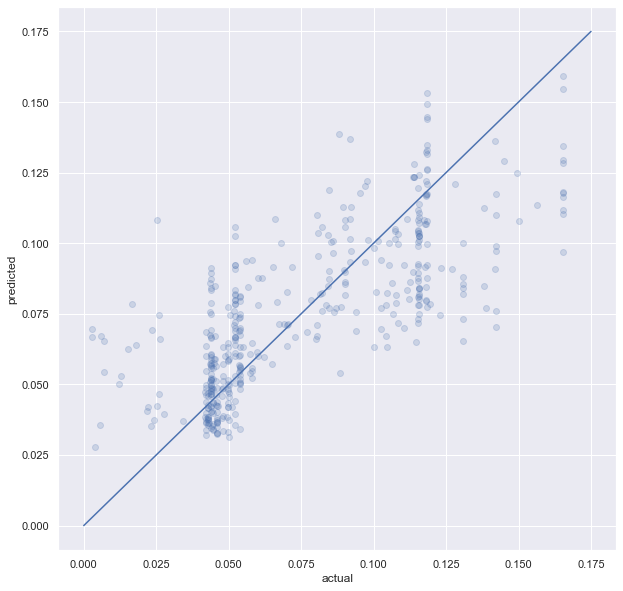

In [232]:
# Fitted vs. Actual
y_train_pred = lg_model.predict(X_train)

plt.scatter(y_train, y_train_pred, alpha=0.2)
plt.plot([0, 0.175], [0, 0.175])

plt.xlabel ('actual')
plt.ylabel ('predicted')
sns.set(rc = {'figure.figsize':(10,10)})



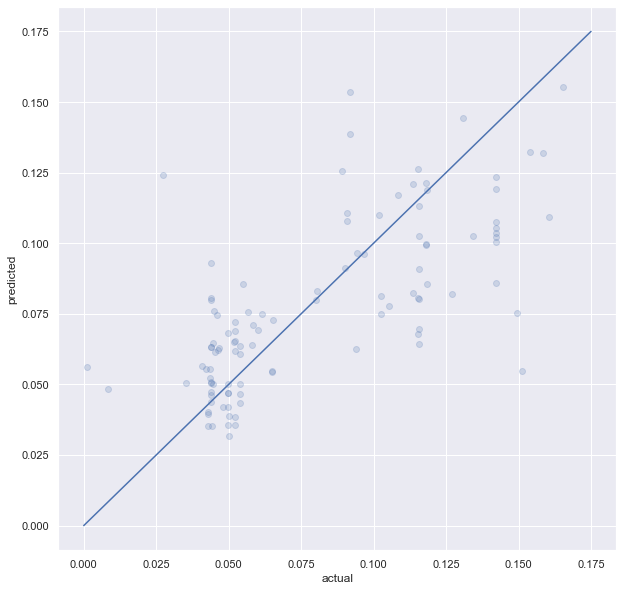

In [233]:
# Fitted vs. Actual
y_test_pred = lg_model.predict(X_test)

plt.scatter(y_test, y_test_pred, alpha=0.2)
plt.plot([0, 0.175], [0, 0.175])

plt.xlabel ('actual')
plt.ylabel ('predicted')
sns.set(rc = {'figure.figsize':(10,10)})

In [234]:
X.columns

Index(['const', 'FGpg', 'ASTpg', 'years_active', 'FGpgxASTpg'], dtype='object')

eval_env: 1


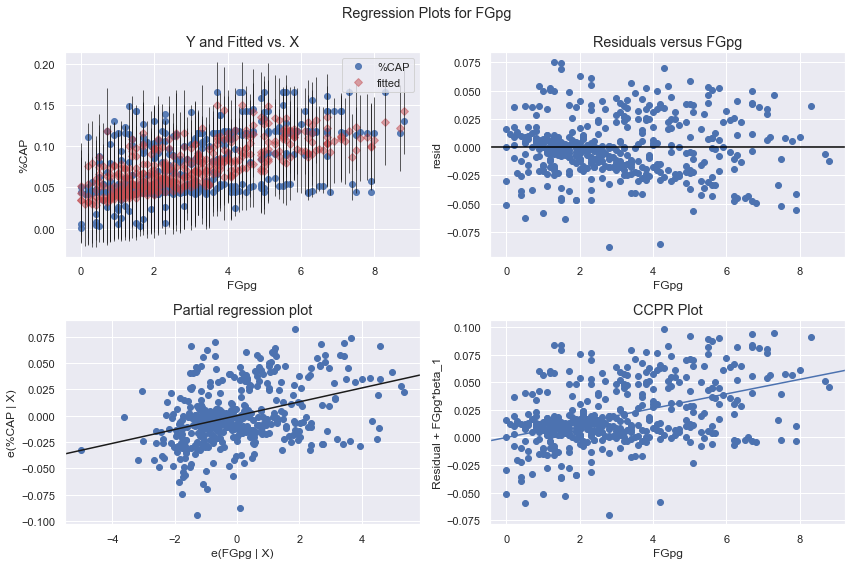

In [75]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'FGpg', fig=fig)


eval_env: 1


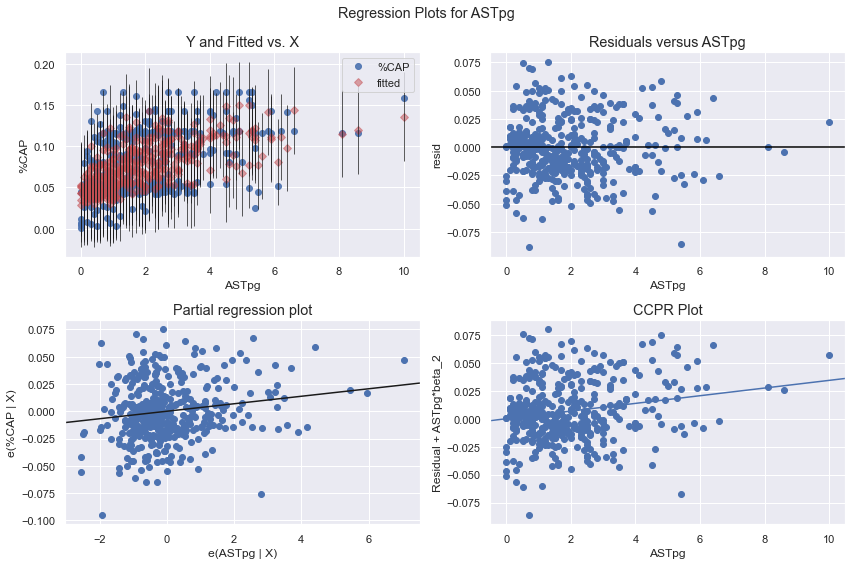

In [76]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'ASTpg', fig=fig)

eval_env: 1


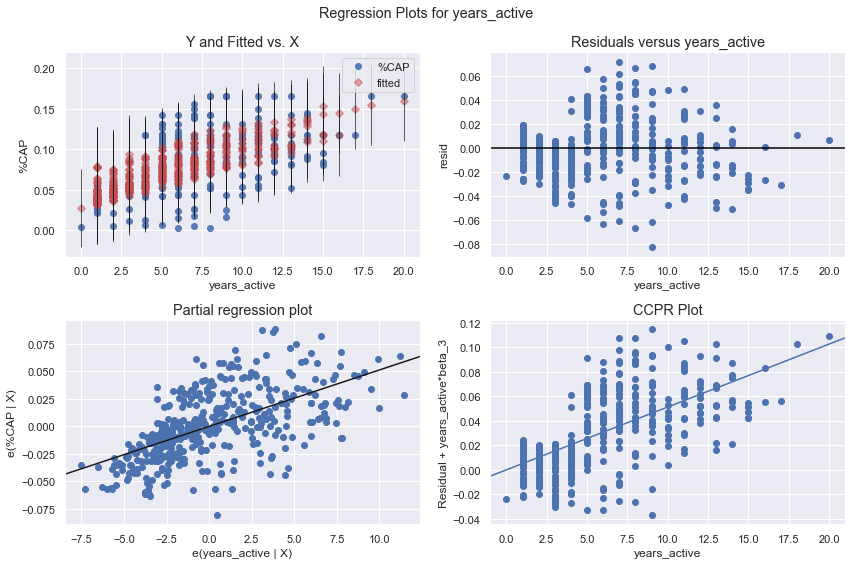

In [235]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'years_active', fig=fig)

In [264]:
df['prediction']= lg_model.predict(df[columns])
df['residual'] = lg_model.predict(df[columns])-df['%CAP']

In [162]:
df.sort_values(['residual']).head()

,Year,Player,Team,Pos,G,MP,GS,FG%,3P%,2P%,...,%CAP,GSxMPpg,MPpgxFGpg,MPpgxASTpg,MPpgxTRBpg,TRBpgxFGpg,FGpgxASTpg,STLpgxASTpg,residual,prediction
206,2020,Jazmine Jones,NYL,G,20,428,2,0.404,0.333,0.429,...,0.151060,856,1498.0,984.4,1754.8,14.35,8.05,3.22,-0.092546,0.058514
110,2021,Alyssa Thomas,CON,F,3,37,0,0.267,0.000,0.267,...,0.149365,0,48.1,48.1,122.1,4.29,1.69,0.39,-0.073014,0.076351
223,2020,Astou Ndour,DAL,C-F,13,151,7,0.351,0.240,0.438,...,0.142308,1057,226.5,75.5,437.9,4.35,0.75,0.10,-0.071073,0.071234
30,2021,Elena Delle Donne,WAS,F-G,3,52,3,0.481,0.600,0.455,...,0.165385,156,223.6,36.4,223.6,18.49,3.01,0.00,-0.068162,0.097223
377,2019,LaToya Sanders,WAS,F-C,34,804,34,0.506,0.000,0.506,...,0.115450,27336,2090.4,1527.6,4422.0,14.30,4.94,1.71,-0.068019,0.047431


In [199]:
df.sort_values(['residual']).tail()

,Year,Player,Team,Pos,G,MP,GS,FG%,3P%,2P%,...,%CAP,GSxMPpg,MPpgxFGpg,MPpgxASTpg,MPpgxTRBpg,TRBpgxFGpg,FGpgxASTpg,STLpgxASTpg,residual,prediction
279,2019,Kayla Alexander,CHI,C,3,20,0,0.750,0.000,0.750,...,0.006093,0,20.0,6.0,46.0,2.30,0.30,0.00,0.061912,0.068005
137,2021,Bria Holmes,TOT,G,19,318,5,0.323,0.242,0.365,...,0.002891,1590,508.8,349.8,826.8,4.16,1.76,0.88,0.065363,0.068254
374,2019,Shey Peddy,WAS,G,15,71,0,0.615,0.500,0.800,...,0.002734,0,35.5,35.5,42.6,0.30,0.25,0.15,0.067515,0.070249
133,2021,Layshia Clarendon,TOT,G,22,543,20,0.517,0.357,0.530,...,0.025328,10860,2280.6,2932.2,1629.0,12.60,22.68,3.24,0.083078,0.108405
135,2021,Candice Dupree,TOT,F,26,463,6,0.435,0.143,0.448,...,0.027290,2778,1296.4,324.1,1389.0,8.40,1.96,0.35,0.094431,0.121721


In [265]:
df.loc[df['Player']=='Liz Cambage',['Year', 'Player', 'Team', 'Pos', 'G', 'MP', 'GS', 'FG%', '3P%', '2P%',
       'FT%', 'MPpg', 'FGpg', '3Ppg', '2Ppg', 'FTpg', 'TRBpg', 'ASTpg' ,
       'STLpg', 'BLKpg', 'PFpg', 'PTSpg','years_active','TTLAllStar','Pick', '%CAP', 'prediction','residual']]

,Year,Player,Team,Pos,G,MP,GS,FG%,3P%,2P%,...,STLpg,BLKpg,PFpg,PTSpg,years_active,TTLAllStar,Pick,%CAP,prediction,residual
14,2021,Liz Cambage,LVA,C,25,595,24,0.543,0.357,0.553,...,0.9,1.6,3.0,14.2,11.0,4.0,2.0,0.165385,0.116506,-0.048878
295,2019,Liz Cambage,LVA,C,32,807,30,0.504,0.167,0.515,...,0.6,1.6,2.8,15.9,9.0,2.0,2.0,0.114446,0.111901,-0.002545
439,2018,Liz Cambage,DAL,C,32,945,32,0.589,0.324,0.611,...,0.5,1.7,2.8,23.0,8.0,1.0,2.0,0.116767,0.124073,0.007306


In [238]:
#Liz Cambage salary prediction salaryd on this years salary cap
0.116506*1379200


160685.0752

In [277]:
check_pred=df[['Player','Year', 'Pos','residual','prediction','%CAP','salary_cap','years_active','ASTpg','FGpg','FGpgxASTpg', 'G', 'MP', 'GS', 'FG%', '3P%', '2P%',
       'FT%', 'MPpg', 'FGpg', '3Ppg', '2Ppg', 'FTpg', 'TRBpg', 'ASTpg' ,
       'STLpg', 'BLKpg', 'PFpg', 'PTSpg','years_active','TTLAllStar','Pick']]

In [278]:
check_pred.to_csv('check_pred.csv')